# Merriam Webster Data Scrape

In this project, I am connecting to the Merriam Webster Dictionary API (https://dictionaryapi.com/) in order to compile information on the words used in Chapters 1-5 of Pride and Prejudice by Jane Austen.

## Libraries

In [64]:
# regular expressions library used to remove punctuation from the chapters
import re
# json library used to read the data returned by the api
import json
# sqlite3 library to create and query from sql database
import sqlite3
# requests library used to connect to the api
import requests
# numpy library used to fill in the empty gaps when information was not present
import numpy as np
# pandas library used to format the data into a neat dataframe
import pandas as pd
# nltk, more specifically stopwords, used to identify and remove stopwords from the corpus
from nltk.corpus import stopwords
#pyplot is used to plot some data visualisations
import matplotlib.pyplot as plt

%matplotlib inline

## Load + Clean Chapter 1-5 of Pride and Prejudice

In [2]:
'''
Loads in Pride and Prejudice Chapter 1 - 5.
Removes new lines, punctuation, and stopwords.
Splits single string into list of words.
'''
with open('Pride and Prejudice Chapters.txt', 'r') as myfile:
    text=myfile.read().replace('\n', ' ')
    
text = re.sub(r'[^\w\s]','',text)
word_list = text.split()
filtered_words = [word for word in word_list if word not in stopwords.words('english')]

len(filtered_words)

2695

## Dictionary Search Function

In [5]:
'''
The dict_search function hits MERRIAM-WEBSTER'S COLLEGIATE® DICTIONARY WITH AUDIO
(https://dictionaryapi.com/products/api-collegiate-dictionary)
'''
def dict_search(word):
    url = "https://www.dictionaryapi.com/api/v3/references/collegiate/json/"
    word = word
    key = "?key=INSERT-YOUR-ACCESS-KEY-HERE"
    req = requests.get(url+word+key)
    cont = json.loads(req.content)
    return cont

## Collecting syllables, noun_verb_adjective, and offensive

In [9]:
'''
Uses the dict_search function to request for information on each word in the
filtered_word list of Chapters 1-5 of Preide and Prejudice by Jane Austen.
Going through, it saves three pieces of information: (1) The number of
syllables in each word, (2) whether it is a noun, verb, adjective, pronoun,
and (3) whether it is classified as offensive.
'''
syllables = []
noun_verb_adjective = []
offensive = []

for word in filtered_words:
    temp = dict_search(word)
    try:
        syllables.append(temp[0]['hwi']['hw'].count('*')+1)
    except:
        syllables.append(np.nan)
    try:
        noun_verb_adjective.append(temp[0]['fl'])
    except:
        noun_verb_adjective.append(np.nan)
    try:
        offensive.append(temp[0]['meta']['offensive'])
    except:
        offensive.append(np.nan)

In [10]:
'''
Formats the four lists into a dataframe.
Each row represents a word and the columns are defined
as the (1) word, (2) number of syllables, (3) noun, verb,
pronoun, or adjective, and (4) whether it is offensive.
'''
p_and_p = pd.DataFrame([filtered_words, syllables, noun_verb_adjective, offensive]).T
p_and_p.columns = ['word', 'syllables', 'noun_verb_adjective', 'offensive']
p_and_p.head()

,word,syllables,noun_verb_adjective,offensive
0,It,1,pronoun,False
1,truth,1,noun,False
2,universally,3,adjective,False
3,acknowledged,3,adjective,False
4,single,2,adjective,False


In [11]:
len(p_and_p)

2695

In [14]:
'''
Function to create sql database from dataframe if database does not
already exist.
'''
def df2sqlite(dataframe, db_name = "import.sqlite", tbl_name = "import"):
 
  conn=sqlite3.connect(db_name)
  cur = conn.cursor()                                 
 
  wildcards = ','.join(['?'] * len(dataframe.columns))              
  data = [tuple(x) for x in dataframe.values]
 
  cur.execute("drop table if exists %s" % tbl_name)
 
  col_str = '"' + '","'.join(dataframe.columns) + '"'
  cur.execute("create table %s (%s)" % (tbl_name, col_str))
 
  cur.executemany("insert into %s values(%s)" % (tbl_name, wildcards), data)
 
  conn.commit()
  conn.close()

In [15]:
df2sqlite(p_and_p, 'p_and_p.sqlite', 'words')

In [16]:
'''
Connecting with the database to retrieve the entire table of words
'''
conn = sqlite3.connect('p_and_p.sqlite')
sqlite_results = pd.read_sql_query('SELECT * '
                       'FROM words '
                       ,conn)
results = pd.DataFrame(sqlite_results)
len(results)

In [24]:
results['offensive'] = results['offensive'].astype(bool)

numpy.float64

In [29]:
results.head()

,word,syllables,noun_verb_adjective,offensive
0,It,1.0,pronoun,False
1,truth,1.0,noun,False
2,universally,3.0,adjective,False
3,acknowledged,3.0,adjective,False
4,single,2.0,adjective,False


## Data Visualisations

### Count of Number of Syllables

In [115]:
'''
Query to group by and get the count of syllables
'''
conn = sqlite3.connect('p_and_p.sqlite')
query = '''
        SELECT COUNT(syllables) count
        FROM words
        GROUP BY syllables
        '''
sqlite_results = pd.read_sql_query(query, conn)

In [116]:
sqlite_results.head()

,count
0,0
1,1477
2,712
3,269
4,68


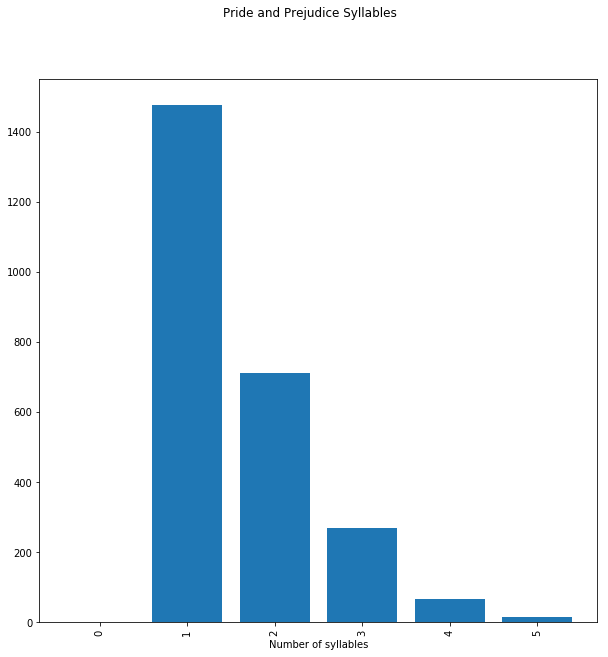

In [117]:
f, ax = plt.subplots(figsize=(10,10))
ax = plt.bar(sqlite_results.index, sqlite_results["count"])
ax = plt.xticks(rotation=90)
f.suptitle("Pride and Prejudice Syllables")
ax = plt.xlabel("Number of syllables")

### Count of Nouns, Verbs, Adjectives and others

In [118]:
'''
Query to get the label as well as the count of noun_verb_adjective
from word after grouping them together and ordering them in descending order.
'''
conn = sqlite3.connect('p_and_p.sqlite')
query = '''
        SELECT noun_verb_adjective, COUNT(noun_verb_adjective) count
        FROM words
        GROUP BY noun_verb_adjective
        ORDER BY COUNT(noun_verb_adjective) DESC
        '''
sqlite_results = pd.read_sql_query(query, conn)

In [119]:
sqlite_results.head()

,noun_verb_adjective,count
0,noun,830
1,verb,549
2,adjective,544
3,adverb,155
4,pronoun,81


Text(0.5,0.98,'Nouns, Verbs, Adjectives')

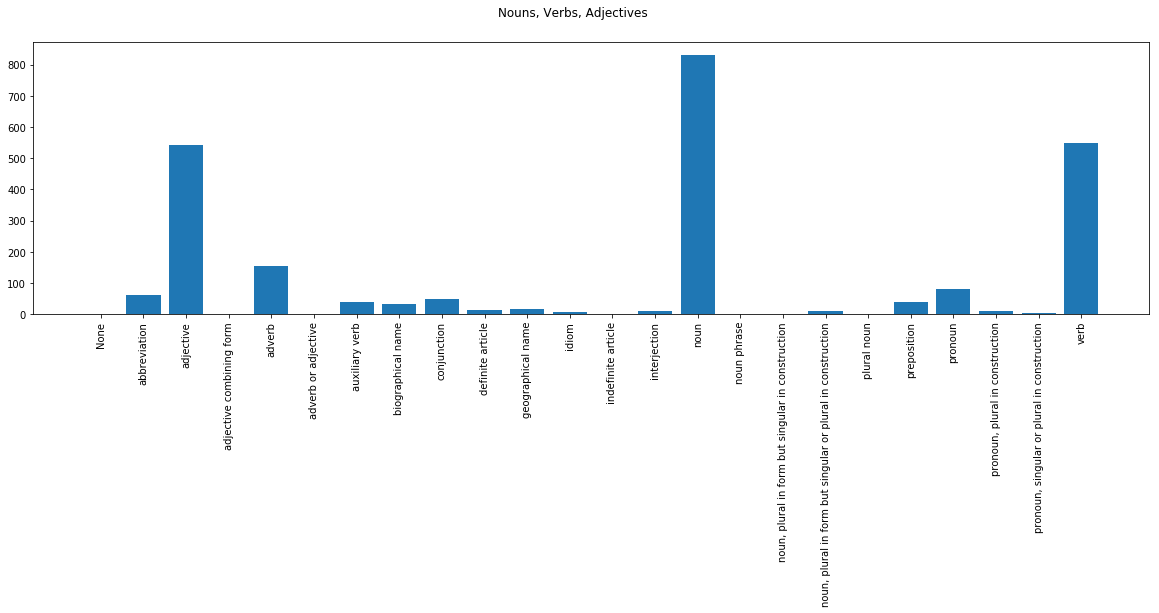

In [120]:
f, ax = plt.subplots(figsize=(20,5))
ax = plt.bar(sqlite_results["noun_verb_adjective"], sqlite_results["count"])
ax = plt.xticks(rotation=90)
f.suptitle("Nouns, Verbs, Adjectives")
